<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9143HPML/blob/main/Lab/Lab3/Lab3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Batch normalization and Dropout are used as effective regularization techniques. However, it is not clear which one should be preferred and whether their benefits add up when used in conjunction. In this problem, we will compare batch normalization, dropout, and their conjunction using MNIST and LeNet-5 (see e.g., http://yann.lecun.com/exdb/lenet/). LeNet-5 is one of the earliest convolutional neural networks developed for image classification and its implementation in all major frameworks is available.

1. Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need to refer to two papers mentioned below to answer this question. (4)
2. Batch normalization is traditionally used in hidden layers, for the input layer standard normalization is used. In standard normalization, the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer? (4)
3. Next instead of standard normalization use batch normalization for the input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for the input layer improve performance? (4)
4. Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3. (4)
5. Now train the network using both batch normalization and dropout. How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone? (4)

*reference:*

* N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, R.Salakhutdinov . Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Available at at https://www.cs.toronto.edu/ rsalakhu/papers/srivastava14a.pdf.
* S. Ioffe, C. Szegedy. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Available at https://arxiv.org/abs/1502.03167.

![image-17](https://user-images.githubusercontent.com/68700549/159705208-dc706e02-6d90-4cea-9304-c3e62e92bc55.png)

## Problem 1

## Problem 2

Batch normalization is traditionally used in hidden layers, for the input layer standard normalization is used. In standard normalization, the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer? (4)

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
class LeNet5(nn.Module):
  def __init__(self, num_classes):
    super(LeNet5, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0),  
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.fc = nn.Linear(400, 120)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(120, 84)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(84, num_classes)


  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.relu(out)
    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)
    return out 

In [23]:
lenet = LeNet5(10)
print(lenet)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [24]:
from torchsummary import summary
summary(lenet, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,750
Trainable params: 

In [2]:
#Loading the dataset and preprocessing
batch_size = 64
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [4]:
training_data = enumerate(train_loader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64])


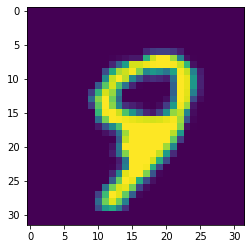

In [71]:
plt.imshow(images[0].squeeze())

## Problem 3
Next instead of standard normalization use batch normalization for the input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for the input layer improve performance? (4)

In [33]:
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)

In [52]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.convolutional_layer = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x

In [53]:
model = LeNet5().to(device)
print(model)

LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [54]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [55]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [58]:
def train(epoch, model, train_acc_history, train_loss_history):   
    model.train()
    correct = 0
    total = 0
    loss_avg = 0
    # training our model
    for idx, (image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        loss_avg += loss.item()
        train_acc_history.append(loss.item())

        loss.backward()
        optimizer.step()

        _, predicted = pred.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item() 
        train_acc_history.append(100. * correct / total)
        print("\nThe batch index: {0:d}, len of train loader: {1:d}, Loss: {2:.3f}, acc: {3:.3f}".format(batch_idx,
                                                                                             len(train_loader),
                                                                                             loss_avg / (batch_idx + 1),
                                                                                             100. * correct / total))

In [59]:
train_acc_history = []
train_loss_history = []
train(1, model, train_acc_history, train_loss_history)


The batch index: 0, len of train loader: 938, Loss: 1.489, acc: 98.438

The batch index: 0, len of train loader: 938, Loss: 2.969, acc: 98.438

The batch index: 0, len of train loader: 938, Loss: 4.441, acc: 98.438

The batch index: 0, len of train loader: 938, Loss: 5.903, acc: 98.828

The batch index: 0, len of train loader: 938, Loss: 7.379, acc: 98.750

The batch index: 0, len of train loader: 938, Loss: 8.842, acc: 98.958

The batch index: 0, len of train loader: 938, Loss: 10.331, acc: 98.884

The batch index: 0, len of train loader: 938, Loss: 11.833, acc: 98.633

The batch index: 0, len of train loader: 938, Loss: 13.333, acc: 98.438

The batch index: 0, len of train loader: 938, Loss: 14.800, acc: 98.594

The batch index: 0, len of train loader: 938, Loss: 16.282, acc: 98.580

The batch index: 0, len of train loader: 938, Loss: 17.761, acc: 98.698

The batch index: 0, len of train loader: 938, Loss: 19.246, acc: 98.678

The batch index: 0, len of train loader: 938, Loss: 20.7

In [72]:
from torchvision.models.feature_extraction import create_feature_extractor

In [74]:
return_nodes = {
    "convolutional_layer.1": "convolutional_layer.1"
}
model2 = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = model2(images[0].reshape((-1, 1,32,32)))


In [94]:

a = intermediate_outputs['convolutional_layer.1'][0].reshape(1, 6*28*28)
a = a.tolist()[0]

Text(0.5, 0, 'sum of predicted value')

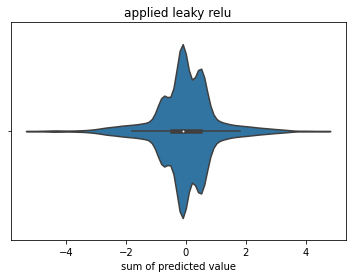

In [95]:
sns.violinplot(x=a)
plt.title('applied leaky relu')
plt.xlabel('sum of predicted value')

In [63]:
for name, layer in model.named_modules():
  print(name, layer)

 LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)
convolutional_layer Sequenti

## Problem 4

Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3. (4)

In [ ]:
class LeNet5_dropout(nn.Module):
  def __init__(self, num_classes):
    super(LeNet5_dropout, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0),  
        # nn.BatchNorm2d(6),
        nn.Dropout2d(p=0.2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0),
        nn.Dropout2d(p=0.5),
        #nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.fc = nn.Linear(400, 120)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(120, 84)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(84, num_classes)

    self.dropout = nn.Dropout(p = 0.5)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.relu(self.dropout(self.fc(out)))
    out = self.relu1(self.dropout(self.fc1(out)))
    out = self.dropout(self.fc2(out))
    return out 

In [ ]:
lenet_dropout = LeNet5_dropout(10)
print(lenet_dropout)

LeNet5_dropout(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
from torchsummary import summary
summary(lenet_dropout, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         Dropout2d-2            [-1, 6, 28, 28]               0
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
         Dropout2d-6           [-1, 16, 10, 10]               0
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
          Dropout-10                  [-1, 120]               0
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
          Dropout-13                   [-1, 84]               0
             ReLU-14                   